In [37]:
!pip install langchain_groq langgraph langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 2.7 MB/s eta 0:00:00


## Pre-built ReAct Agent

In [31]:
import os
from langchain_groq import ChatGroq


from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

# To create llm object, make sure you have 'GROQ_API_KEY' in your environment variable
# comment above line of code where we are fetching colab userdata.

llm = ChatGroq(temperature=0.9, model_name="llama-3.1-8b-instant")
response = llm.invoke("hi")
response.content

'How can I assist you today?'

In [38]:
from langchain_openai import ChatOpenAI


llm_openai = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, api_key=userdata.get("OPENAI_API_KEY"))

In [43]:
from langgraph.prebuilt import create_react_agent

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

def calculate(expression):
    """Calculate a mathematical expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {str(e)}"

agent = create_react_agent(
    llm_openai,
    tools=[get_weather, calculate],
    prompt="You are a helpful assistant."
)

# Run the agent
response = agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in delhi. also tell me what is 3 times 43 and what is the weather at Mumbai."}]}
)

In [44]:
response

{'messages': [HumanMessage(content='what is the weather in delhi. also tell me what is 3 times 43 and what is the weather at Mumbai.', additional_kwargs={}, response_metadata={}, id='ee3c64bd-6232-4039-9ac6-7e5243ce8b9c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KhTFlGzoGlFiJ6s4q7TLcRtO', 'function': {'arguments': '{"city": "delhi"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_7N8mtqfJ3RJiRxsUSB1Yzt5I', 'function': {'arguments': '{"expression": "3*43"}', 'name': 'calculate'}, 'type': 'function'}, {'id': 'call_wb4GQrP1dmQdylvLSKghOFFv', 'function': {'arguments': '{"city": "Mumbai"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 96, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens

In [45]:
for item in response["messages"]:
  print(type(item))
  print(item)
  print()

<class 'langchain_core.messages.human.HumanMessage'>
content='what is the weather in delhi. also tell me what is 3 times 43 and what is the weather at Mumbai.' additional_kwargs={} response_metadata={} id='ee3c64bd-6232-4039-9ac6-7e5243ce8b9c'

<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'tool_calls': [{'id': 'call_KhTFlGzoGlFiJ6s4q7TLcRtO', 'function': {'arguments': '{"city": "delhi"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_7N8mtqfJ3RJiRxsUSB1Yzt5I', 'function': {'arguments': '{"expression": "3*43"}', 'name': 'calculate'}, 'type': 'function'}, {'id': 'call_wb4GQrP1dmQdylvLSKghOFFv', 'function': {'arguments': '{"city": "Mumbai"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 96, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'pro

In [46]:
print(response["messages"][-1].content)

The weather in Delhi is always sunny! The result of 3 times 43 is 129. The weather in Mumbai is also always sunny!


## Building from Scratch

In [48]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [55]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

# model = llm
model = llm_openai

@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"


tools = [get_weather]

model = model.bind_tools(tools)

In [56]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

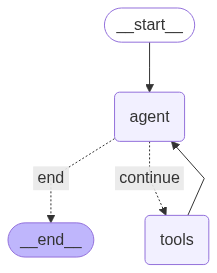

In [57]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [58]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_LpEf1yJGGxkHr8mVtp2EhU55)
 Call ID: call_LpEf1yJGGxkHr8mVtp2EhU55
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

"It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."
================================== Ai Message ==================================

The weather in San Francisco is sunny! Just a heads up if you're a Gemini! 🌞
